In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pandas as pd

In [6]:
df=pd.read_csv('/content/drive/MyDrive/fypcodee/data/Sinhala_news_articles.csv')
texts = df['Title'].values
labels = df['Label'].values
print(texts)
print(labels)

['කොරෝනා වැලඳුණු ට්\u200dරම්ප් අද ජන රැලියක'
 'ආර්ථික විද්\u200dයාව පිළිබඳ නොබෙල් ත්\u200dයාගය ඇමරිකානුවන් දෙදෙනෙකුට'
 'ඉන්දියාවේ කොරෝනා ආසාදිතයන් 71 ලක්ෂය ඉක්මවයි' ...
 'ශ්\u200dරී ලංකා - ඕස්ට්\u200dරේලියා 3 වන තරගය හෙට.'
 'බංග්ලාදේශය පාකිස්ථානයට ?' 'නවතම ක්\u200dරිකට් ශ්\u200dරේණිගත කිරීම්.']
['International' 'International' 'International' ... 'Sport' 'Sport'
 'Sport']


In [8]:
stop_words = []

# Load your dataset
f = open("/content/drive/MyDrive/fypcodee/static/model/stop words.txt", "r", encoding='utf-8')
for x in f:
    stop_words.append(x)

def remove_stopwords(texts, stopwords):
    filtered_texts = []
    for text in texts:
        # Tokenize the text into words
        words = text.split()
        # Remove stop words from the custom list (case insensitive)
        filtered_words = [word for word in words if word.lower() not in stopwords]
        # Join the words back into a filtered sentence
        filtered_texts.append(' '.join(filtered_words))
    return filtered_texts

# Remove stopwords from texts using the custom stopwords list
texts = remove_stopwords(texts, stop_words)

In [10]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498210 sha256=35aefb5fe34c349a55fa9a02c110aef6470ed3e60b3ad2a1e5b0e1f3af1cb4b9
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


In [11]:
import fasttext
import tensorflow as tf
import pickle

import numpy as np
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/2
2114/2114 ━━━━━━━━━━━━━━━━━━━━ 126s 57ms/step - accuracy: 0.5085 - loss: 0.9912 - val_accuracy: 0.6516 - val_loss: 0.7800
Epoch 2/2
2114/2114 ━━━━━━━━━━━━━━━━━━━━ 113s 53ms/step - accuracy: 0.6818 - loss: 0.7503 - val_accuracy: 0.7018 - val_loss: 0.6913
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
Confusion Matrix:
 [[ 387  429  249]
 [  40 1934  428]
 [  19  410 1388]]


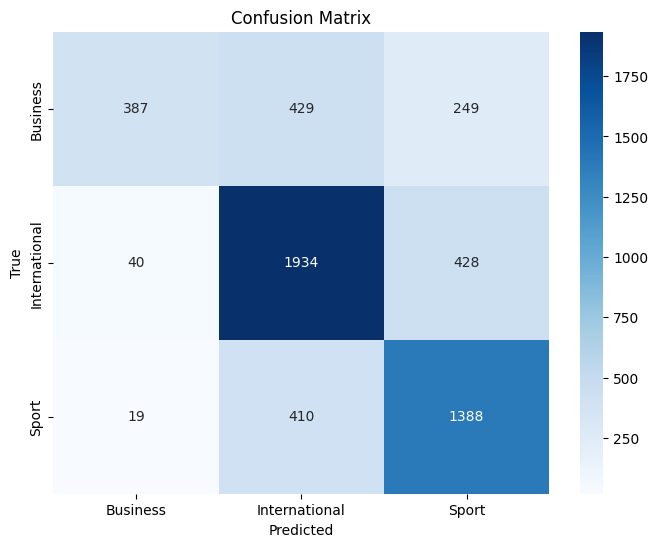


Classification Report:
                precision    recall  f1-score   support

     Business       0.87      0.36      0.51      1065
International       0.70      0.81      0.75      2402
        Sport       0.67      0.76      0.72      1817

     accuracy                           0.70      5284
    macro avg       0.75      0.64      0.66      5284
 weighted avg       0.72      0.70      0.69      5284

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Probabilities: [0.09682103 0.65669996 0.24647897]
Predicted Label: International


In [13]:
tf.random.set_seed(42)

embedding_dim = 300
max_vocab_size = 10000
max_sequence_length = 20


label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(labels)

categorical_labels = to_categorical(integer_encoded_labels)


tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, categorical_labels, test_size=0.2,stratify=categorical_labels ,random_state=42)


ft_model = fasttext.load_model('/content/drive/MyDrive/fypcodee/fastText/cc.si.300.bin')

word_vectors = {word: ft_model.get_word_vector(word) for word in set(texts)}
embedding_matrix = np.zeros((len(word_vectors) + 1, embedding_dim))
word_index = {word: i + 1 for i, word in enumerate(word_vectors.keys())}
for word, i in word_index.items():
    embedding_matrix[i] = word_vectors[word]


model = Sequential([
    Embedding(input_dim=len(word_index) + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_sequence_length,
              trainable=False),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])


model.compile(loss='categorical_crossentropy',  # For multiclass classification
              optimizer='adam',
              metrics=['accuracy'])


model.fit(X_train, y_train, epochs=2, batch_size=8, validation_split=0.2)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print("\nClassification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))


def preprocess_and_predict_multiclass(text, tokenizer, model, max_sequence_length, label_encoder):

    sequence = tokenizer.texts_to_sequences([text])

    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')

    prediction = model.predict(padded_sequence)[0]

    predicted_class_index = np.argmax(prediction)
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
    return prediction, predicted_class_label


new_text = "කොරෝනා වැලඳුණු ට්‍රම්ප් අද ජන රැලියක"


probabilities, predicted_label = preprocess_and_predict_multiclass(new_text, tokenizer, model, max_sequence_length, label_encoder)

print(f"Predicted Probabilities: {probabilities}")
print(f"Predicted Label: {predicted_label}")

# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)

# with open('label_encoder.pkl', 'wb') as f:
#     pickle.dump(label_encoder, f)

# model.save("model.h5")  # Saving in HDF5 format



In [16]:
import pickle

with open('/content/drive/MyDrive/fypcodee/static/model/tokenizer.pkl', 'wb') as f:
  pickle.dump(tokenizer, f)

with open('/content/drive/MyDrive/fypcodee/static/model/label_encoder.pkl', 'wb') as f:
  pickle.dump(label_encoder, f)

model.save("/content/drive/MyDrive/fypcodee/static/model/model.h5")  # Saving in HDF5 format